In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor as rf
import xgboost as xgb
import math
import warnings
import model.visualset
warnings.filterwarnings('ignore')

In [2]:
model.visualset.Graphset()

In [3]:
# data load
all_df = pd.read_csv('../data/smart_farm.csv')
all_df = all_df.iloc[:,1:]

In [4]:
for colname in all_df.columns:
    newName = colname[11:]
    print(newName)
    all_df.rename(columns={colname:newName},inplace=True)

yy
mm
dd
hh
nn
insolation
out_tmperature
out_humidity
wind_speed
wind_direction
in_tmperature
in_humidity
shield_light_h
shield_tmperature_h
shield_energy_h
shield_energy_v
exhaust_fan
ceiling
floating_fan
fan_coil_b_site
ventilation_temperature_control
heating_temperature_set_up
heat_supply


In [5]:
# 날짜 Index가 여러개 있어서 하나로 정리하고싶을 때 실행
# date = all_df[['yy','mm','dd','hh','nn']].astype(str).apply('-'.join,axis=1)
date = all_df[['yy','mm','dd']].astype(str).apply('-'.join,axis=1)
time = all_df[['hh','nn']].astype(str).apply(':'.join,axis=1)
datetime = date + ' ' + time
all_df.insert(loc=0,column='date',value=datetime)
all_df['date'] = pd.to_datetime(all_df['date'])

In [6]:
all_df['date'].value_counts().sort_values()

2021-11-26 00:00:00    1
2021-11-26 00:08:00    1
2021-11-26 00:02:00    1
2021-11-26 00:03:00    1
2021-11-26 00:04:00    1
                      ..
2022-03-20 23:52:00    1
2022-03-20 23:53:00    1
2022-03-20 23:54:00    1
2022-03-20 23:56:00    1
2022-03-20 23:59:00    1
Name: date, Length: 152640, dtype: int64

In [7]:
all_df['heat_supply'].isnull().sum()

21177

<AxesSubplot:xlabel='date'>

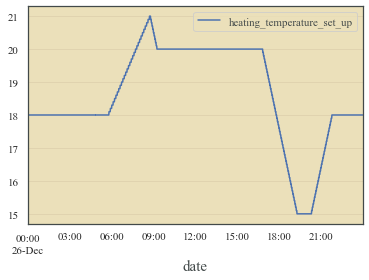

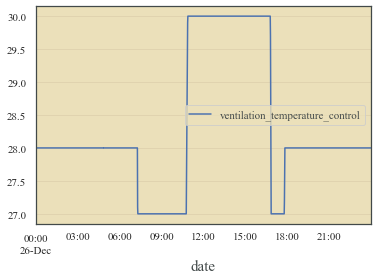

In [8]:
graph_df = all_df[all_df['date'].between('2021-12-26 00:00:00', '2021-12-26 23:59:59')]
graph_df[['date','out_tmperature','out_humidity','in_humidity','ventilation_temperature_control','heating_temperature_set_up','in_tmperature','out_tmperature','ceiling','heat_supply','insolation']].plot(x='date',y='heating_temperature_set_up')
graph_df[['date','out_tmperature','out_humidity','ventilation_temperature_control','heating_temperature_set_up']].plot(x='date',y='ventilation_temperature_control')


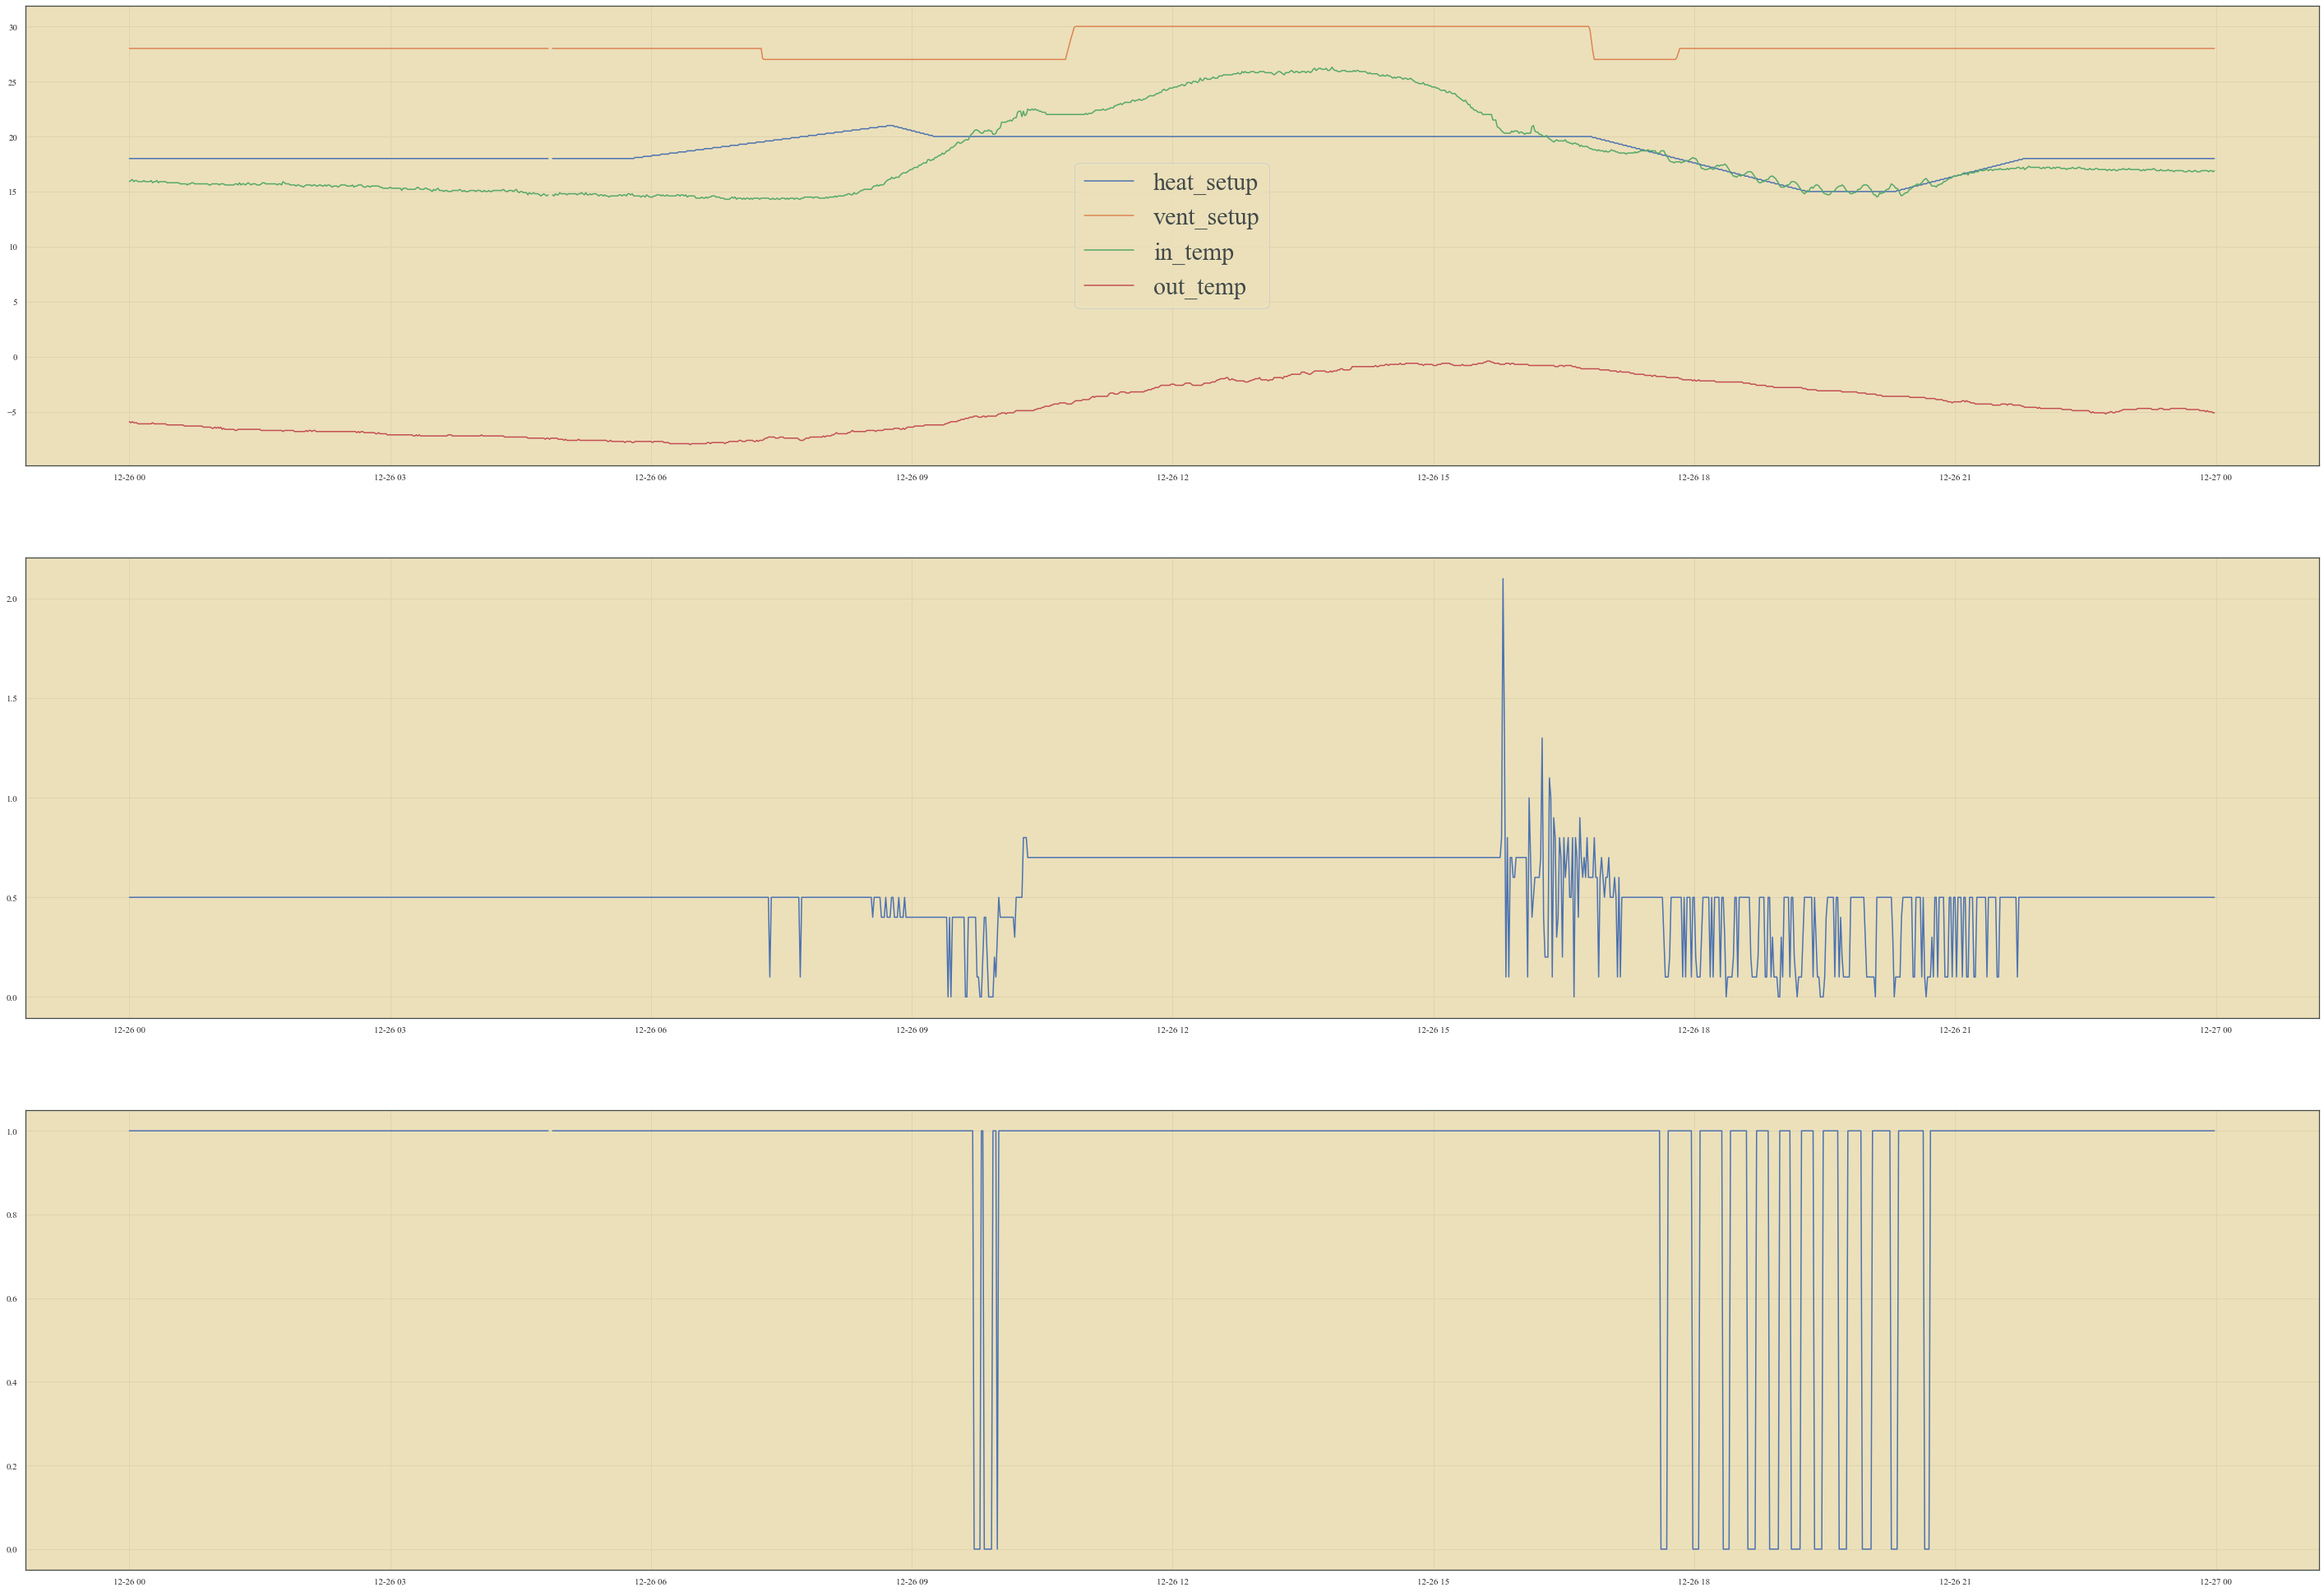

In [80]:
fig, ax = plt.subplots(3,1, figsize=(50,35))
# plt.figure(figsize=(50,10))
ax[0].plot(graph_df['date'],graph_df['heating_temperature_set_up'])
ax[0].plot(graph_df['date'],graph_df['ventilation_temperature_control'])
ax[0].plot(graph_df['date'],graph_df['in_tmperature'])
ax[0].plot(graph_df['date'],graph_df['out_tmperature'])

# plt.plot(graph_df['date'],graph_df['in_humidity'])
ax[0].legend(['heat_setup','vent_setup','in_temp','out_temp',], prop={'size':30})
ax[1].plot(graph_df['date'],graph_df['heat_supply'])
ax[2].plot(graph_df['date'],graph_df['fan_coil_b_site'])

# plt.plot(graph_df['date'],graph_df['out_tmperature'])
# plt.plot(graph_df['date'],graph_df['ceiling'])
# plt.plot(graph_df['date'],graph_df['heat_supply'])
    

In [14]:
all_df.to_csv("data/all_df.csv",index=False)

In [15]:
# 스마트팜 내부제어 요소 리스트
List_Control = ['shield_light_h','shield_tmperature_h','shield_energy_h','shield_energy_v','exhaust_fan','ceiling','floating_fan','fan_coil_b_site','heat_supply']

In [16]:
all_df_corr = all_df.drop(['date'],axis=1)
all_df_corr = all_df_corr.corr()

In [17]:
cont_df = all_df[List_Control]
cont_df_corr = cont_df.corr()

<AxesSubplot:>

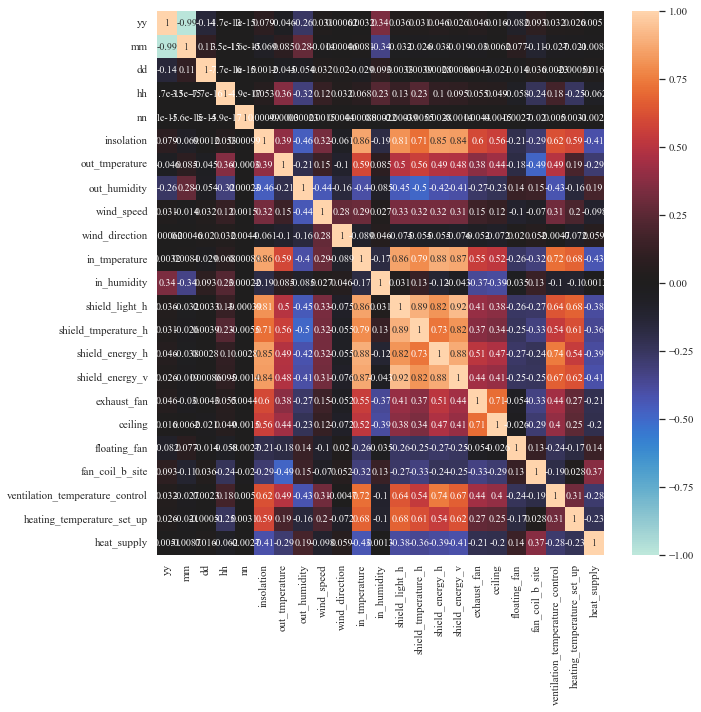

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(all_df_corr,vmax=1, vmin=-1, center=0, annot=True)

<AxesSubplot:>

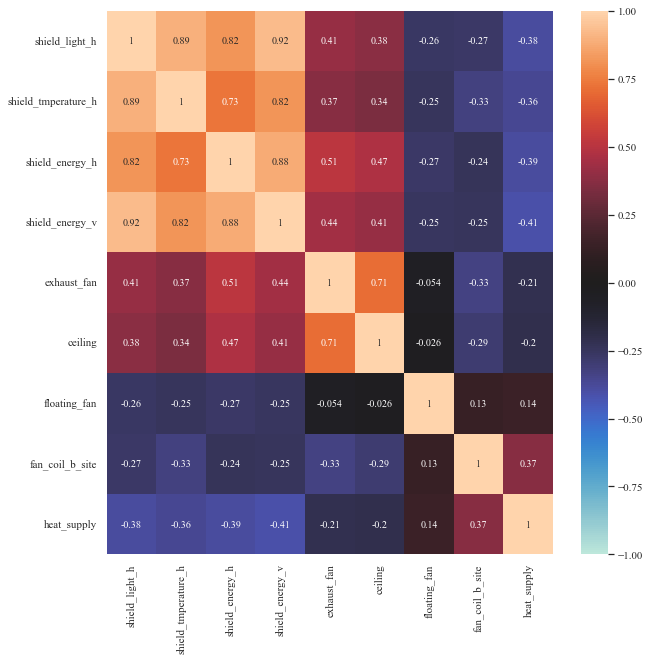

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(cont_df_corr,vmax=1, vmin=-1, center=0, annot=True)

In [20]:
all_df_corr['heat_supply'].abs().sort_values(ascending=False)

heat_supply                        1.000000
in_tmperature                      0.433335
shield_energy_v                    0.408185
insolation                         0.408037
shield_energy_h                    0.388191
shield_light_h                     0.384404
fan_coil_b_site                    0.373128
shield_tmperature_h                0.364154
out_tmperature                     0.291589
ventilation_temperature_control    0.282265
heating_temperature_set_up         0.230081
exhaust_fan                        0.214179
ceiling                            0.204157
out_humidity                       0.187190
floating_fan                       0.140951
wind_speed                         0.097829
hh                                 0.062197
wind_direction                     0.059303
dd                                 0.015692
mm                                 0.008736
yy                                 0.005080
nn                                 0.002713
in_humidity                     

<AxesSubplot:>

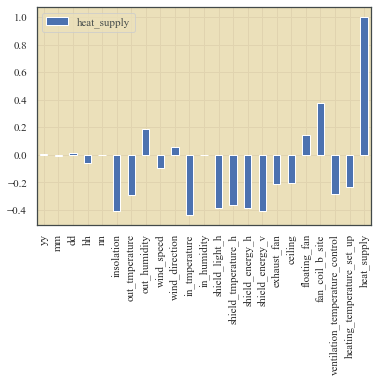

In [21]:
all_df_corr.plot.bar(y='heat_supply')

In [22]:
control_per_hour = all_df[['hh','shield_energy_h','shield_energy_v','fan_coil_b_site','shield_light_h','heat_supply']].groupby('hh').mean()
control_per_hour['heat_supply'] = control_per_hour['heat_supply'] * 60
control_per_hour

,shield_energy_h,shield_energy_v,fan_coil_b_site,shield_light_h,heat_supply
hh,,,,,
0,0.000000,0.056604,0.793868,0.000000,28.303242
1,0.000000,0.056604,0.806132,0.000000,27.679705
2,0.000000,0.056604,0.817138,0.000000,27.430356
3,0.000000,0.056604,0.834277,0.000000,28.015247
4,0.000000,0.056604,0.847937,0.000000,27.014746
5,0.000000,0.056604,0.899371,0.000000,27.564130
6,0.000000,0.056630,0.956426,0.000000,28.511180
7,0.000000,1.846276,0.967737,0.445833,28.470652
8,1.760410,21.452366,0.837066,32.355994,24.828261


In [23]:
from model.train import trainer
from model.predict import predictor
import yaml
with open('model/setting/params.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [24]:
train_df = all_df.dropna()
train_df.to_csv('data/train_df.csv',index=False)

In [25]:
train_X = train_df.drop(['date', 'heat_supply'],axis=1)
train_Y = train_df['heat_supply']

In [26]:
test1_df = all_df[all_df['date'].between('2022-03-04 00:00:00', '2022-03-13 23:59:59')]
test2_df = all_df[all_df['date'].between('2022-03-18 00:00:00', '2022-03-23 23:59:59')]

test1_df.to_csv("data/test1_df.csv",index=False)
test2_df.to_csv("data/test2_df.csv",index=False)

test1_X = test1_df.drop(['date', 'heat_supply'],axis=1)
test2_X = test2_df.drop(['date', 'heat_supply'],axis=1)

In [27]:
test2_df.head()

,date,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
148320,2022-03-18 00:00:00,2022,3,18,0,0,-1.5,7.0,92,1.3,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
148321,2022-03-18 00:01:00,2022,3,18,0,1,-1.5,7.0,92,1.3,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
148322,2022-03-18 00:02:00,2022,3,18,0,2,-1.4,7.0,92,1.3,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
148323,2022-03-18 00:03:00,2022,3,18,0,3,-1.4,7.0,92,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
148324,2022-03-18 00:04:00,2022,3,18,0,4,-1.1,7.1,92,1.8,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN


In [28]:
tr = trainer()
pred = predictor()

tr.train_lgb(train_X, train_Y, params['lgb'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 104652, number of used features: 22
[LightGBM] [Info] Start training from score 0.359473
[1]	valid_0's l2: 0.135417
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.134027
[3]	valid_0's l2: 0.133556
[4]	valid_0's l2: 0.131583
[5]	valid_0's l2: 0.130408
[6]	valid_0's l2: 0.128277
[7]	valid_0's l2: 0.126574
[8]	valid_0's l2: 0.125527
[9]	valid_0's l2: 0.123887
[10]	valid_0's l2: 0.123114
[11]	valid_0's l2: 0.121937
[12]	valid_0's l2: 0.121826
[13]	valid_0's l2: 0.121216
[14]	valid_0's l2: 0.121124
[15]	valid_0's l2: 0.120344
[16]	valid_0's l2: 0.120219
[17]	valid_0's l2: 0.119816
[18]	valid_0's l2: 0.119715
[19]	valid_0's l2: 0.119121
[20]	v

In [29]:
pred.predict_lgb(tr.models_lgb[0], test1_X)
pred.predict_lgb(tr.models_lgb[0], test2_X)

In [30]:
submission = pd.read_csv('submit/submit.csv')

In [31]:
submission.head()

,yy_from,mm_from,dd_from,yy_to,mm_to,dd_to,heat_supply_sum
0,2022,3,4,2022,3,13,NaN
1,2022,3,18,2022,3,23,NaN


In [32]:
preds_ans1 = pred.preds_lgb[0].sum()
preds_ans2 = pred.preds_lgb[1].sum()

In [33]:
submission['heat_supply_sum'] = np.array([preds_ans1,preds_ans2])

In [34]:
submission.to_csv('submit/220156.csv',index=False)

In [35]:

cont_df = all_df[List_Control]
cont_df = cont_df.dropna(axis=0)[List_Control]
cont_X = cont_df.iloc[:,:-1]
cont_y = cont_df.iloc[:,-1]


In [53]:
cont_X.shape

(130951, 8)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(cont_X, cont_y, test_size = 0.2, random_state=1)
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

LinearRegression()

In [40]:
X_pred = model_linear.predict(X_test)


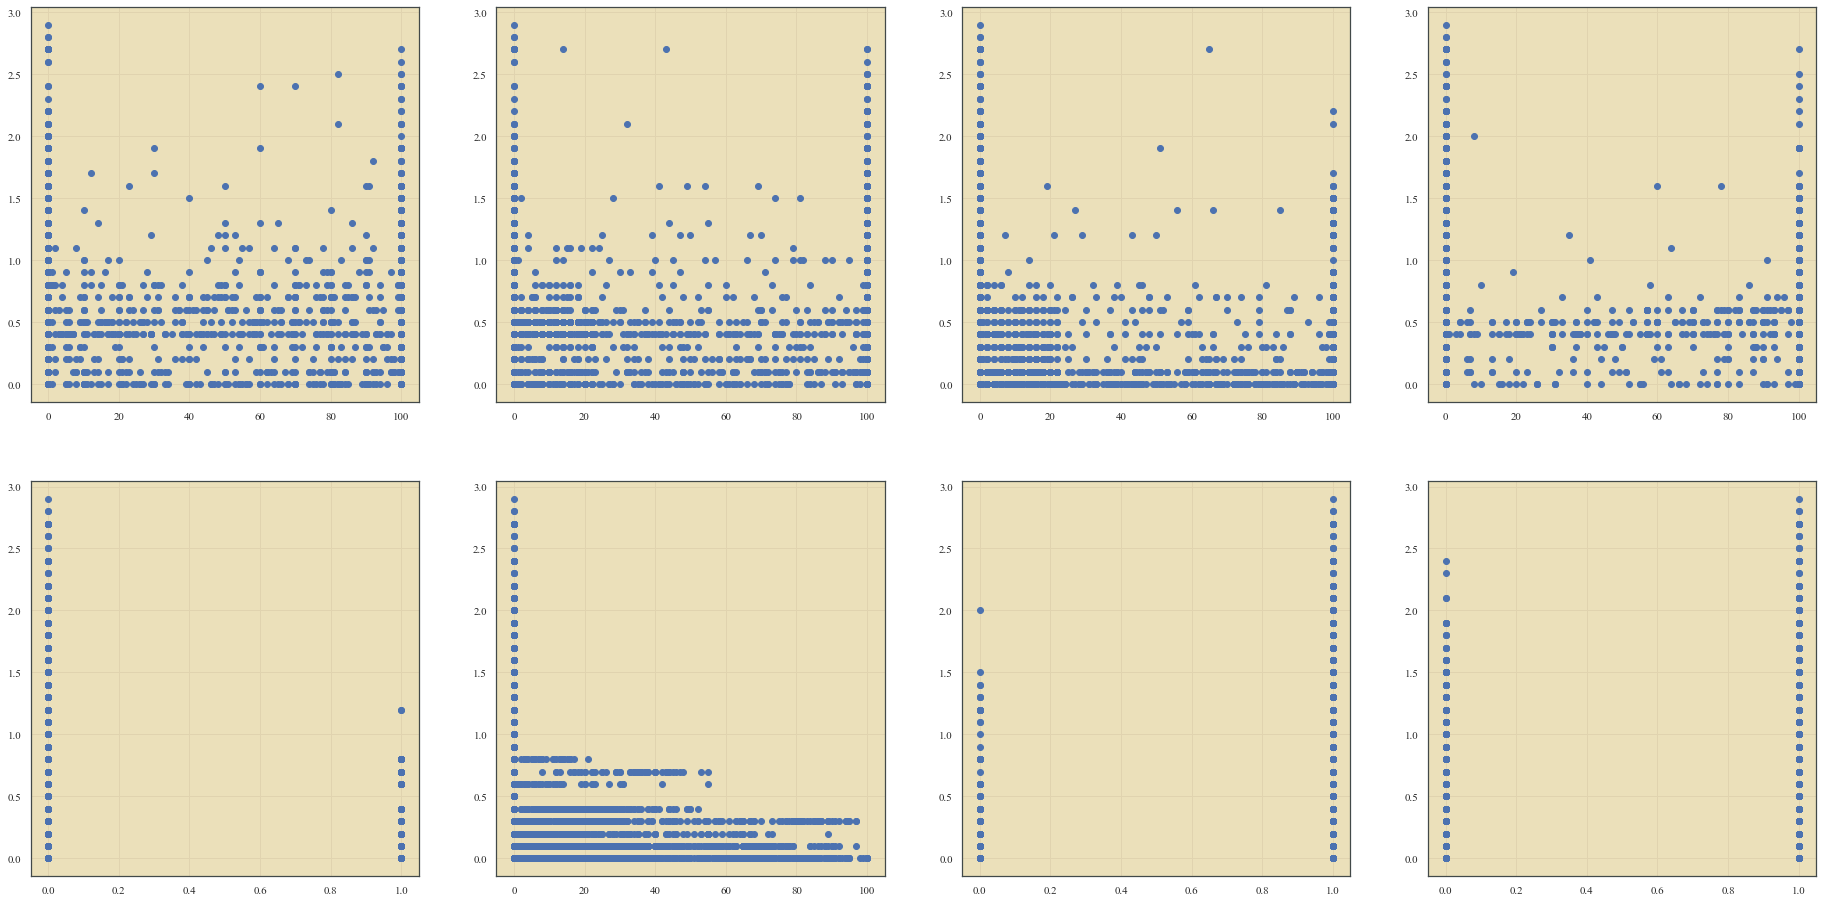

In [72]:
##그래프로 시각화해보기
fig, ax = plt.subplots(2,4, figsize=(32, 16))    
ax[0][0].scatter(X_test['shield_light_h'],y_test)
ax[0][1].scatter(X_test['shield_tmperature_h'],y_test)
ax[0][2].scatter(X_test['shield_energy_h'],y_test)
ax[0][3].scatter(X_test['shield_energy_v'],y_test)
ax[1][0].scatter(X_test['exhaust_fan'],y_test)
ax[1][1].scatter(X_test['ceiling'],y_test)
ax[1][2].scatter(X_test['floating_fan'],y_test)
ax[1][3].scatter(X_test['fan_coil_b_site'],y_test)

# x와 예측 데이터 값으로 그래프 그리기
# ax[1].plot(, X_pred, color='b')

# ax[1].set_xlabel('x')
# ax[1].set_ylabel('y')

In [ ]:
y_test_pred = model_linear.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = math.sqrt(mse)
print(rmse)


0.2782898764415272


In [ ]:
all_df[['heat_supply','fan_coil_b_site']].head(50)

,heat_supply,fan_coil_b_site
0,0.9,0.0
1,0.9,0.0
2,0.9,1.0
3,0.8,1.0
4,1.0,1.0
5,1.0,1.0
6,0.9,1.0
7,0.8,1.0
8,0.9,1.0
9,0.9,1.0
